## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [47]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [48]:
# Just had to see what this looked like

#train_files
#train_targets
#valid_files
#valid_targets
#test_files
#test_targets
#dog_names

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [49]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


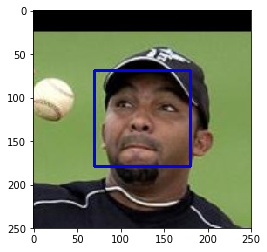

In [50]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[np.random.randint(0,len(human_files))])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [51]:
# put the code above into a function for use below.

def find_face(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    print (faces,"\n")

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [52]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [53]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_files_short_results = []

for img in human_files_short:
    human_files_short_results.append(face_detector(img))

human_answer = np.round((np.sum(human_files_short_results) / len(human_files_short)) * 100, 2)
print('Percentage of first 100 images that detected human faces for HUMAN Dataset:',human_answer,'%')

dog_files_short_results = []

for img in dog_files_short:
    dog_files_short_results.append(face_detector(img))

dog_answer = np.round((np.sum(dog_files_short_results) / len(dog_files_short)) * 100, 2)
print('Percentage of first 100 images that detected human faces for for DOG Dataset:',dog_answer,'%')

Percentage of first 100 images that detected human faces for HUMAN Dataset: 100.0 %
Percentage of first 100 images that detected human faces for for DOG Dataset: 11.0 %


In [54]:
#get a list of the false positives to visualize

false_positives = []

index = 0
while index < len(dog_files_short_results):
    if dog_files_short_results[index]:
        false_positives.append(index)
        index+=1
    else:
        index+=1

In [55]:
#false positives for the DOG dataset

false_positives

[0, 14, 15, 21, 22, 23, 24, 30, 32, 63, 78]

Number of faces detected: 1


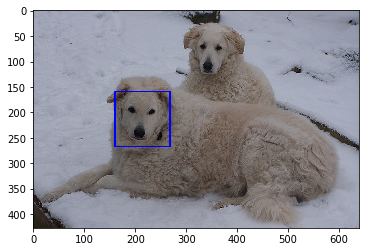

[[160 159 108 108]] 

Number of faces detected: 1


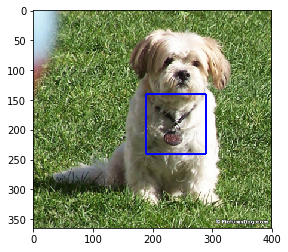

[[189 140 100 100]] 

Number of faces detected: 1


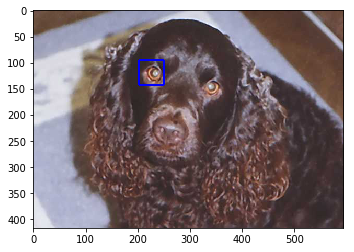

[[202  95  48  48]] 

Number of faces detected: 1


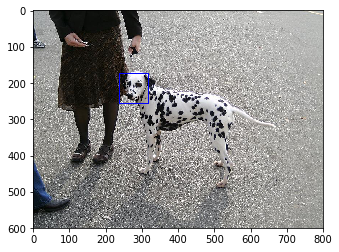

[[237 175  81  81]] 

Number of faces detected: 1


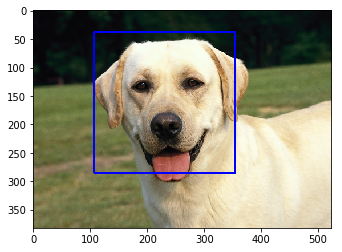

[[107  38 247 247]] 

Number of faces detected: 1


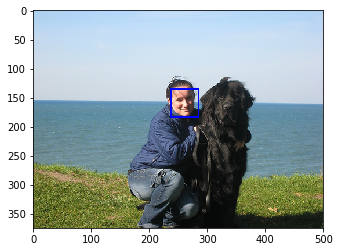

[[237 135  48  48]] 

Number of faces detected: 1


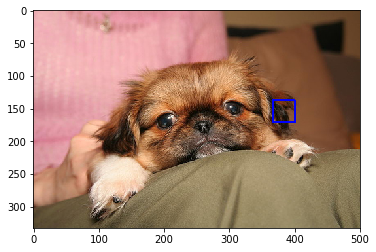

[[366 137  34  34]] 

Number of faces detected: 1


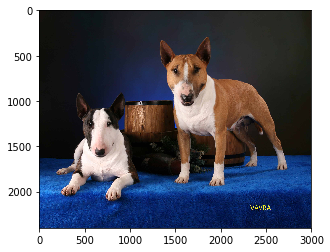

[[1078 1034   44   44]] 

Number of faces detected: 1


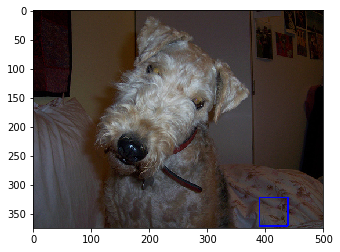

[[390 322  49  49]] 

Number of faces detected: 1


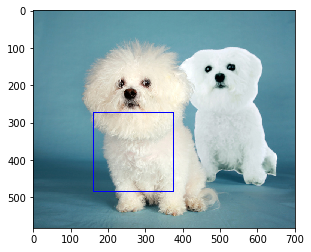

[[162 272 213 213]] 

Number of faces detected: 1


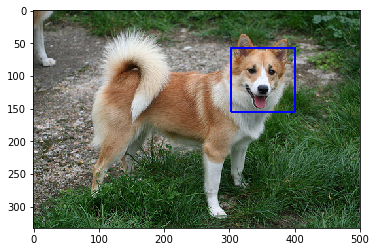

[[302  57  98  98]] 



In [56]:
# display all the false positives from the DOG test files
from IPython.display import Image

for i in false_positives:
    #display(Image(dog_files_short[i], width=200, height=200))
    find_face(dog_files_short[i])

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [57]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

__Answer:__

In my opinion it is reasonable to expect that images meet some specifications espeically if you can make clear what the expectations are.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [58]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [59]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [60]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [61]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [62]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short_results_2 = []

for img in human_files_short:
    human_files_short_results_2.append(dog_detector(img))

human_answer_2 = np.round((np.sum(human_files_short_results_2) / len(human_files_short)) * 100,1)
print('Percentage of first 100 images that detected DOGS for the HUMAN Dataset:',human_answer_2,'%')

dog_files_short_results_2 = []

for img in dog_files_short:
    dog_files_short_results_2.append(dog_detector(img))

dog_answer_2 = np.round((np.sum(dog_files_short_results_2) / len(dog_files_short)) * 100, 1)
print('Percentage of first 100 images that detected DOGS for the DOG Dataset:',dog_answer_2,'%')

Percentage of first 100 images that detected DOGS for the HUMAN Dataset: 0.0 %
Percentage of first 100 images that detected DOGS for the DOG Dataset: 100.0 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [63]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:10<00:00, 81.42it/s] 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

The architecture that you see below is what I have landed at after a bit of experimentation. I decided to use the architecture provided above as a starting point and see how much I could improve it. 

This is had led me down the following approximate path:
- Replicate the results above with the suggested architecture.
    - ~ 1% accuracy
- Remove the GAP layer after the convolution layers and replace with another MaxPool layer. 
    - ~ 10% accuracy
- Experimenting with Dropout layers after the MaxPool and Fully Connected layers to help reduce overfit on the training data.
    - ~ 10% accuracy
- Experimenting with the size and number of the fully connected layers
    - ~ 10% accuracy
- Experimenting with the number of epochs to train the model
    - ~ 10% accuracy
- Experiment with BatchNormalization after each conv layer
    - ~ 10% accuracy
    
*Although it makes the code block below a big ugly. I've left in a bunch of commented out lines that shows some of the things I was trying here in getting to the architecture I've arrived at.*
    
I'm still developing my intition as to *why* this works per se. But I believe it goes something like this:
- The Conv2D layers build feature maps of what's contained in the images.
- As the number of filters increases with each Conv2D layer, the detail in the each feature map increases.
  - Ie. We move from edge detection and detection of blobs/areas of color towards filters that begin to resemble the kinds of details that seem intuitive to a human eye.
- I've used relu activation for all the layers until the softmax activation for the final fully connected layer in order to get a probabilty for each class.
- I added a Flatten layer after the last max pooling layer in order to transition from the Max Pooling layers to the fully connected Dense layers.
- I added a dropout layer towards the end as I saw that the model was starting to overfit on the training data with no subsequent decrease in validation loss.

In [64]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(input_shape=(224, 224, 3), filters=16, kernel_size=2, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
#model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
#model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
#model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=1))
#model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 128)       32896     
__________

### Compile the Model

In [65]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [66]:
from keras.callbacks import ModelCheckpoint

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 15

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 33s 5ms/step - loss: 4.8745 - acc: 0.0114 - val_loss: 4.6951 - val_acc: 0.0228
Epoch 2/15
6680/6680 [==============================] - 28s 4ms/step - loss: 4.5366 - acc: 0.0397 - val_loss: 4.4195 - val_acc: 0.0455
Epoch 3/15
6680/6680 [==============================] - 28s 4ms/step - loss: 4.1880 - acc: 0.0702 - val_loss: 4.1736 - val_acc: 0.0778
Epoch 4/15
6680/6680 [==============================] - 28s 4ms/step - loss: 3.8750 - acc: 0.1099 - val_loss: 4.0281 - val_acc: 0.0946
Epoch 5/15
6680/6680 [==============================] - 28s 4ms/step - loss: 3.4670 - acc: 0.1841 - val_loss: 3.9342 - val_acc: 0.1030
Epoch 6/15
6680/6680 [==============================] - 28s 4ms/step - loss: 2.9042 - acc: 0.2786 - val_loss: 4.0604 - val_acc: 0.1018
Epoch 7/15
6680/6680 [==============================] - 28s 4ms/step - loss: 2.2227 - acc: 0.4316 - val_loss: 4.6628 - val_acc: 0.1257
Epoch 8/

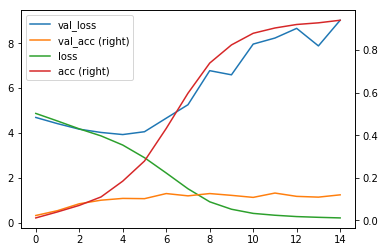

In [67]:
#ADAPTED FROM HERE:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# https://stackoverflow.com/questions/36952763/how-to-return-history-of-validation-loss-in-keras

training = pd.DataFrame.from_dict(hist.history)
training.plot(secondary_y=['acc', 'val_acc'])

### Load the Model with the Best Validation Loss

In [68]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [69]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.5694%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [70]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [71]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [72]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [73]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

hist1 = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=150, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/150
6680/6680 [==============================] - 3s 457us/step - loss: 12.8890 - acc: 0.0951 - val_loss: 11.1857 - val_acc: 0.1844
Epoch 2/150
6680/6680 [==============================] - 2s 306us/step - loss: 10.6038 - acc: 0.2476 - val_loss: 10.3952 - val_acc: 0.2683
Epoch 3/150
6680/6680 [==============================] - 2s 308us/step - loss: 10.0869 - acc: 0.3135 - val_loss: 10.1782 - val_acc: 0.2994
Epoch 4/150
6680/6680 [==============================] - 2s 303us/step - loss: 9.7422 - acc: 0.3504 - val_loss: 9.9755 - val_acc: 0.3090
Epoch 5/150
6680/6680 [==============================] - 2s 304us/step - loss: 9.4998 - acc: 0.3690 - val_loss: 9.8745 - val_acc: 0.3030
Epoch 6/150
6680/6680 [==============================] - 2s 309us/step - loss: 9.3518 - acc: 0.3853 - val_loss: 9.8269 - val_acc: 0.3090
Epoch 7/150
6680/6680 [==============================] - 2s 309us/step - loss: 9.2419 - acc: 0.3973 - val_loss: 9.5805 - val_

6680/6680 [==============================] - 2s 301us/step - loss: 6.9305 - acc: 0.5594 - val_loss: 7.8633 - val_acc: 0.4419
Epoch 28/150
6680/6680 [==============================] - 2s 301us/step - loss: 6.8829 - acc: 0.5651 - val_loss: 7.7879 - val_acc: 0.4419
Epoch 29/150
6680/6680 [==============================] - 2s 300us/step - loss: 6.8038 - acc: 0.5690 - val_loss: 7.7412 - val_acc: 0.4479
Epoch 30/150
6680/6680 [==============================] - 2s 314us/step - loss: 6.7211 - acc: 0.5716 - val_loss: 7.6361 - val_acc: 0.4563
Epoch 31/150
6680/6680 [==============================] - 2s 317us/step - loss: 6.6505 - acc: 0.5804 - val_loss: 7.6537 - val_acc: 0.4551
Epoch 32/150
6680/6680 [==============================] - 2s 314us/step - loss: 6.6256 - acc: 0.5840 - val_loss: 7.6297 - val_acc: 0.4659
Epoch 33/150
6680/6680 [==============================] - 2s 315us/step - loss: 6.6173 - acc: 0.5849 - val_loss: 7.5992 - val_acc: 0.4527
Epoch 34/150
6680/6680 [=======================

Epoch 56/150
6680/6680 [==============================] - 2s 313us/step - loss: 6.0175 - acc: 0.6202 - val_loss: 7.3351 - val_acc: 0.4886
Epoch 57/150
6680/6680 [==============================] - 2s 311us/step - loss: 5.9963 - acc: 0.6231 - val_loss: 7.3463 - val_acc: 0.4862
Epoch 58/150
6680/6680 [==============================] - 2s 319us/step - loss: 5.9815 - acc: 0.6246 - val_loss: 7.3593 - val_acc: 0.4838
Epoch 59/150
6680/6680 [==============================] - 2s 317us/step - loss: 5.9783 - acc: 0.6251 - val_loss: 7.3920 - val_acc: 0.4922
Epoch 60/150
6680/6680 [==============================] - 2s 318us/step - loss: 5.9738 - acc: 0.6260 - val_loss: 7.3086 - val_acc: 0.5006
Epoch 61/150
6680/6680 [==============================] - 2s 310us/step - loss: 5.9666 - acc: 0.6266 - val_loss: 7.2991 - val_acc: 0.4946
Epoch 62/150
6680/6680 [==============================] - 2s 311us/step - loss: 5.9630 - acc: 0.6275 - val_loss: 7.2768 - val_acc: 0.4970
Epoch 63/150
6680/6680 [==========

Epoch 87/150
6680/6680 [==============================] - 2s 304us/step - loss: 5.9534 - acc: 0.6301 - val_loss: 7.3471 - val_acc: 0.4898
Epoch 88/150
6680/6680 [==============================] - 2s 305us/step - loss: 5.9520 - acc: 0.6299 - val_loss: 7.3395 - val_acc: 0.4946
Epoch 89/150
6680/6680 [==============================] - 2s 305us/step - loss: 5.9510 - acc: 0.6304 - val_loss: 7.3877 - val_acc: 0.4850
Epoch 90/150
6680/6680 [==============================] - 2s 309us/step - loss: 5.9535 - acc: 0.6301 - val_loss: 7.3095 - val_acc: 0.4862
Epoch 91/150
6680/6680 [==============================] - 2s 310us/step - loss: 5.9523 - acc: 0.6305 - val_loss: 7.3256 - val_acc: 0.4850
Epoch 92/150
6680/6680 [==============================] - 2s 308us/step - loss: 5.9527 - acc: 0.6302 - val_loss: 7.3259 - val_acc: 0.4910
Epoch 93/150
6680/6680 [==============================] - 2s 310us/step - loss: 5.9505 - acc: 0.6302 - val_loss: 7.3375 - val_acc: 0.4958
Epoch 94/150
6680/6680 [==========

Epoch 119/150
6680/6680 [==============================] - 2s 301us/step - loss: 5.9515 - acc: 0.6304 - val_loss: 7.3704 - val_acc: 0.4898
Epoch 120/150
6680/6680 [==============================] - 2s 298us/step - loss: 5.9506 - acc: 0.6305 - val_loss: 7.3768 - val_acc: 0.4898
Epoch 121/150
6680/6680 [==============================] - 2s 296us/step - loss: 5.9504 - acc: 0.6305 - val_loss: 7.3629 - val_acc: 0.4898
Epoch 122/150
6680/6680 [==============================] - 2s 301us/step - loss: 5.9485 - acc: 0.6307 - val_loss: 7.4044 - val_acc: 0.4838
Epoch 123/150
6680/6680 [==============================] - 2s 301us/step - loss: 5.9522 - acc: 0.6305 - val_loss: 7.3710 - val_acc: 0.4910
Epoch 124/150
6680/6680 [==============================] - 2s 300us/step - loss: 5.9492 - acc: 0.6307 - val_loss: 7.3746 - val_acc: 0.4814
Epoch 125/150
6680/6680 [==============================] - 2s 305us/step - loss: 5.9516 - acc: 0.6305 - val_loss: 7.3810 - val_acc: 0.4826
Epoch 126/150
6680/6680 [==

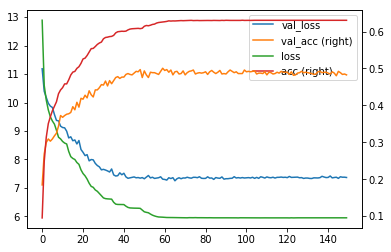

In [74]:
training1 = pd.DataFrame.from_dict(hist1.history)
training1.plot(secondary_y=['acc', 'val_acc'])

### Load the Model with the Best Validation Loss

In [75]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [76]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.6842%


### Predict Dog Breed with the Model

In [77]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [78]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- I have chosen Resnet50 to conduct the transfer learning. When I first selected it, I honestly didn't even think about why one would be better than the other. I had chosen Resnet50. After now doing some research, I'm thinking I'd have chosen the Xception model as it seems to perform even better than Resnet50 and InceptionV3. See ref below.

https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

- It's likely that Resnet50 will significantly outperform my clunky model above as it's been designed specifically for the purpose of image classification by a leading team of experts. Additionally, it uses many more hidden layers that have been carefully designed and implemented for this purpose. It has also already been pre-trained on a much larger training set which includes dogs.

- In order to arrive at this architecture I started with just the GlobalAveragePooling layer and the Dense layer with softmax activation. From there I have experimented with Substituting the GlobalAveragePooling for MaxPooling, adding in a fully connected dense layer of varying size (256 -> 1024) and adding an aggressive Dropout layer to help reduce overfitting on the training set.
- It's no longer shown in the code but I had attemped to augment the training set but I was struggling to implement this correctly. I was hopeful that could boost my performance from 75-80% to 90+%. Alas I could not get this implemented.

In [99]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
#Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(MaxPooling2D(input_shape=train_Resnet50.shape[1:],pool_size=1))
Resnet50_model.add(Flatten())
#Resnet50_model.add(Dense(1024))
#Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_22 (MaxPooling (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [97]:
### TODO: Compile the model.

Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [98]:
from keras.preprocessing.image import ImageDataGenerator

### TODO: Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

hist2 = Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 467us/step - loss: 1.6077 - acc: 0.6097 - val_loss: 0.8592 - val_acc: 0.7257
Epoch 2/20
6680/6680 [==============================] - 2s 279us/step - loss: 0.4395 - acc: 0.8597 - val_loss: 0.7256 - val_acc: 0.7796
Epoch 3/20
6680/6680 [==============================] - 2s 275us/step - loss: 0.2662 - acc: 0.9109 - val_loss: 0.6783 - val_acc: 0.8000
Epoch 4/20
6680/6680 [==============================] - 2s 275us/step - loss: 0.1806 - acc: 0.9424 - val_loss: 0.6910 - val_acc: 0.8024
Epoch 5/20
6680/6680 [==============================] - 2s 285us/step - loss: 0.1217 - acc: 0.9620 - val_loss: 0.7163 - val_acc: 0.8036
Epoch 6/20
6680/6680 [==============================] - 2s 275us/step - loss: 0.0875 - acc: 0.9741 - val_loss: 0.6681 - val_acc: 0.8192
Epoch 7/20
6680/6680 [==============================] - 2s 274us/step - loss: 0.0638 - acc: 0.9802 - val_loss: 0.7218 - val_acc: 0.8096
E

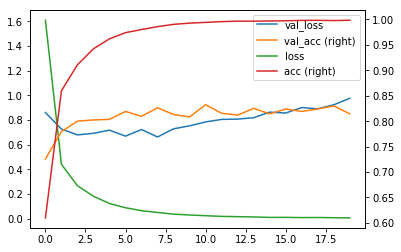

In [100]:
training2 = pd.DataFrame.from_dict(hist2.history)
training2.plot(secondary_y=['acc', 'val_acc'])

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [101]:
### TODO: Load the model weights with the best validation loss.

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [102]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy_Resnet50 = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy_Resnet50)

Test accuracy: 80.6220%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [103]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

/data/dog_images/train/095.Kuvasz/Kuvasz_06442.jpg


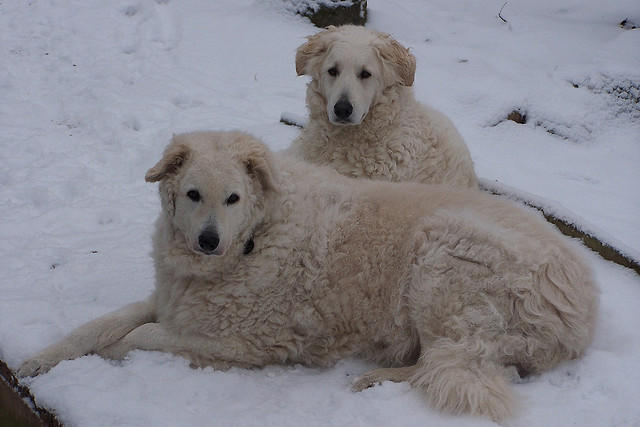

94658560/94653016 [==============================] - 2s 0us/step


'in/095.Kuvasz'

In [104]:
#quick test on the dog_files_short set

print (dog_files_short[0])
display(Image(dog_files_short[0], width=200, height=200))
Resnet50_predict_breed(dog_files_short[0])

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [105]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def who_let_the_dogs_out(img_path):
    if face_detector(img_path):
        print ('Hello human.')
        display(Image(img_path, width=200, height=200))
        breed = Resnet50_predict_breed(img_path)
        print ('You look like a...\n',breed)
    elif dog_detector(img_path):
        print ('Hello fury friend.')
        breed = Resnet50_predict_breed(img_path)
        display(Image(img_path, width=200, height=200))
        print ('You look like a...\n',breed)
    else:
        print ("Somethings gone wrong here. I don't see either a dog or a human here. Please try a different image.")
        display(Image(img_path, width=200, height=200))
    return None

In [109]:
##quick test

image_index = 13

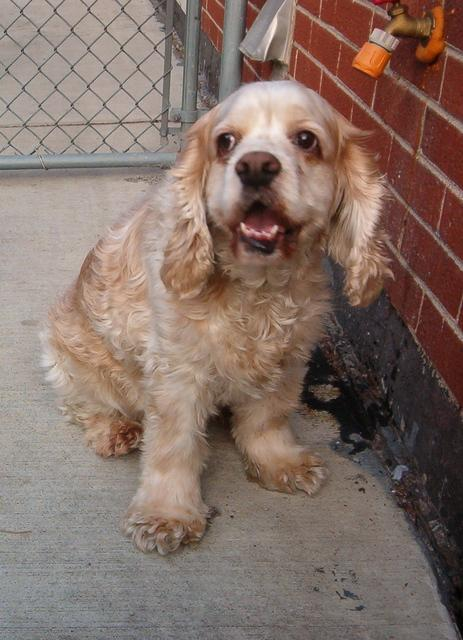

In [110]:
display(Image(dog_files_short[image_index], width=200, height=200))

Hello fury friend.


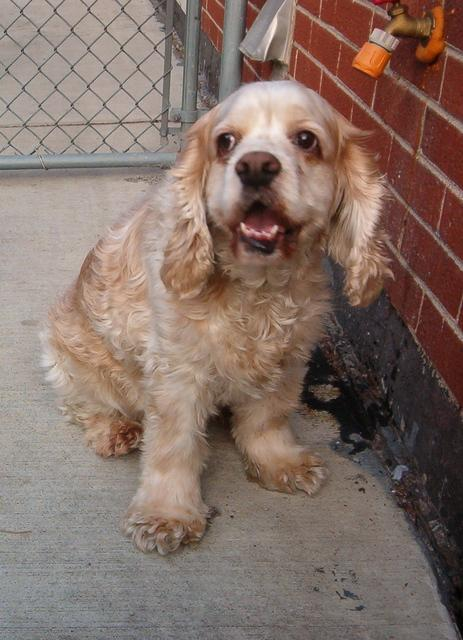

You look like a...
 in/053.Cocker_spaniel


In [111]:
who_let_the_dogs_out(dog_files_short[image_index])

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [112]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

test_imgs = []

for file in glob("test_imgs/*.jpg"):
    test_imgs.append(file)

In [113]:
test_imgs

['test_imgs/IMG_20161224_214357.jpg',
 'test_imgs/IMG_20190202_132446.jpg',
 'test_imgs/IMG_20180120_100219.jpg']

__Accuracy on dogs__

To start with, these were three recent photos of dogs I had on my phone. 
1. The first image is a winner. That is a dog and it's an Irish Setter mix named Lore. So Yay!
2. The second one is again Lore but for some reason I believe the Face Detector is seeing Frida Karlos face on the pillow in the foreground. I'll check this in a code cell below.
3. The thrid one is more surprising. It's a picture of a dog. Hmmm. I'll check the Face Detector for this one too below.

Number of faces detected: 2


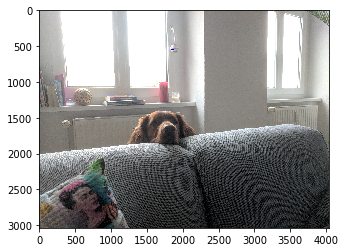

[[1837  499   51   51]
 [ 269 1046   54   54]] 



In [114]:
find_face(test_imgs[1])

Number of faces detected: 1


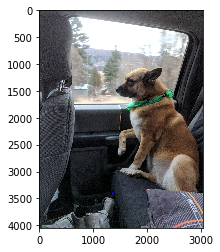

[[1344 3389   51   51]] 



In [115]:
find_face(test_imgs[2])

- The face fetector see's two tiny faces in the second image (test_imgs[1]). The rectangles are drawn but they are hard to see as they are small. They are on the christmas decoration hanging from the window handle and on the books sitting on the window sill.
- When I run the code block above for the third image (test_imgs[2]), I get a similar result. The face detector is seeing a face in image on the edge of seat in what looks to be a strange, very darka area of the image.
- I wonder if this is due to the input images being much larger in size therefore there is a much larger oppurtunity for the face detector to find a face. I will rescale the images to 224 by 224 as with the other images and see if this improves the result.

In [116]:
## as above, after investigating what the CV face detector was seeing, I rescaled the dog images to 224 by 224 pixels.
## stolen from here: https://www.daniweb.com/programming/software-development/code/216637/resize-an-image-python

from PIL import Image as IMG

height = 224
width = 224

index = 0
index1 = 1

while index < len(test_imgs):
    file = IMG.open(test_imgs[index])
    newfile = file.resize((width, height), IMG.NEAREST)
    ext = ".jpg"
    newfile.save('test_imgs/' + "NEAREST" + str(index1) + ext)
    index += 1
    index1 += 1

In [117]:
test_imgs_rescale = []

for file in glob("test_imgs/NEAREST*"):
    test_imgs_rescale.append(file)

In [118]:
test_imgs_rescale

['test_imgs/NEAREST1.jpg', 'test_imgs/NEAREST2.jpg', 'test_imgs/NEAREST3.jpg']

Hello fury friend.


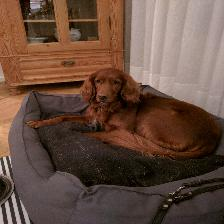

You look like a...
 in/047.Chesapeake_bay_retriever


Somethings gone wrong here. I don't see either a dog or a human here. Please try a different image.


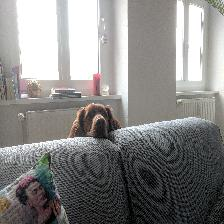



Somethings gone wrong here. I don't see either a dog or a human here. Please try a different image.


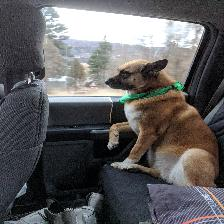

In [119]:
for img in test_imgs_rescale:
    who_let_the_dogs_out(img)
    print("\n")

- After rescaling, the second and third images now show neither a human or a dog. I'm still surprised about the thrid image as that is fairly clearly a dog in my opinion.
- Let's now set it loose on headshots from the Golden State Warriors current roster and see what we get. All the images are .png so we can easily create a separate list and pass them to the function.

In [120]:
warriors_imgs = []

for file in glob("test_imgs/*.png"):
    warriors_imgs.append(file)

Hello human.


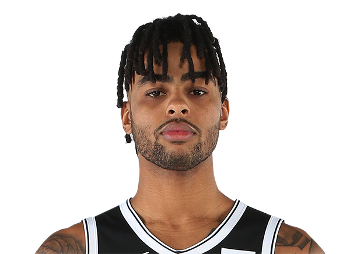

You look like a...
 in/016.Beagle


Hello human.


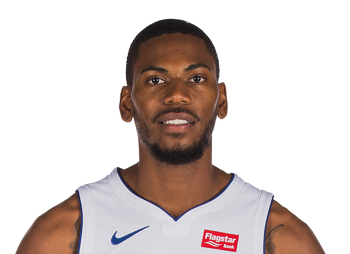

You look like a...
 in/016.Beagle


Hello human.


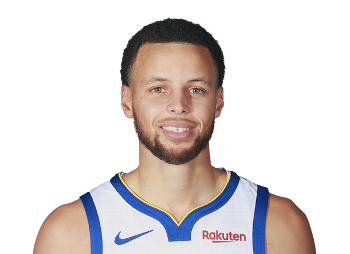

You look like a...
 in/016.Beagle


Hello human.


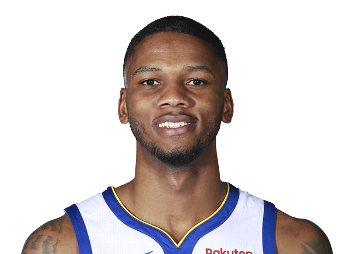

You look like a...
 in/016.Beagle


Hello human.


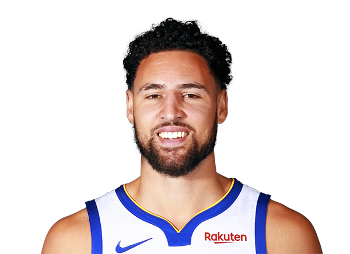

You look like a...
 in/016.Beagle


Hello human.


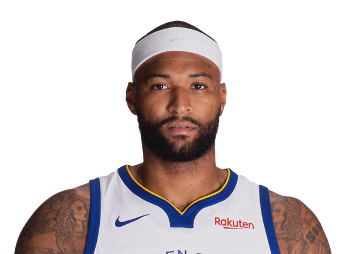

You look like a...
 in/016.Beagle


Hello human.


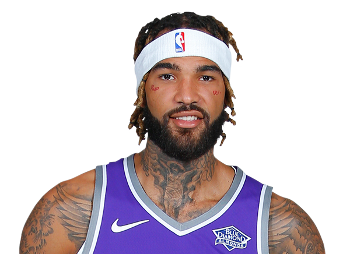

You look like a...
 in/041.Bullmastiff


Hello human.


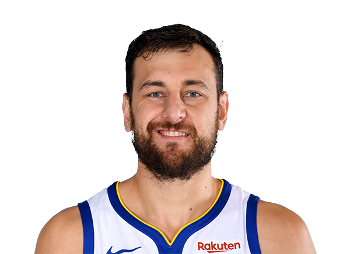

You look like a...
 in/016.Beagle


Hello human.


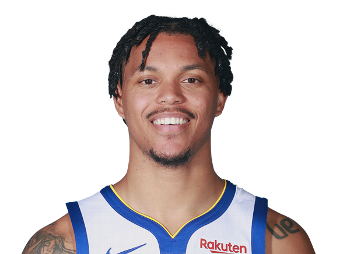

You look like a...
 in/041.Bullmastiff


Hello human.


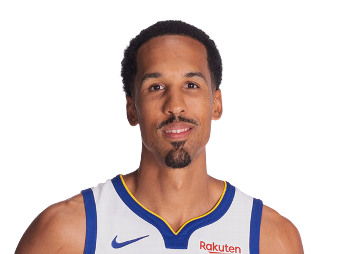

You look like a...
 in/016.Beagle


Hello human.


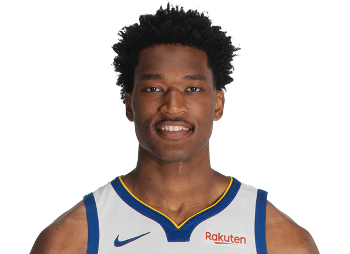

You look like a...
 in/016.Beagle


Hello human.


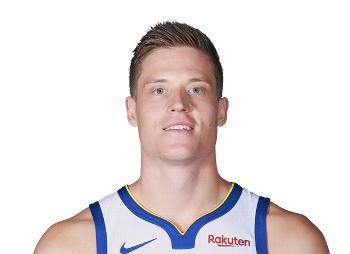

You look like a...
 in/016.Beagle


Hello human.


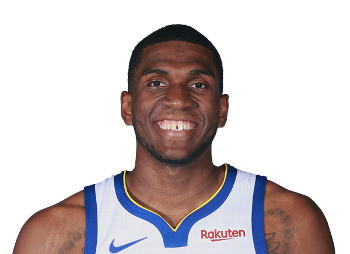

You look like a...
 in/041.Bullmastiff


Hello human.


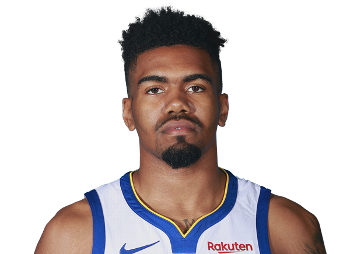

You look like a...
 in/041.Bullmastiff


Hello human.


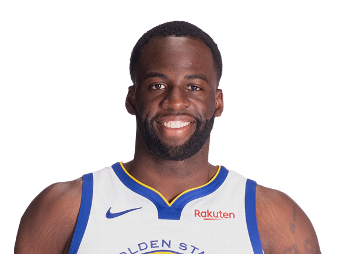

You look like a...
 in/016.Beagle


Hello human.


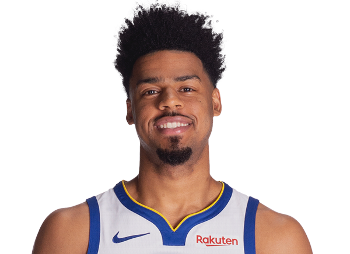

You look like a...
 in/016.Beagle




In [121]:
for img in warriors_imgs:
    who_let_the_dogs_out(img)
    print("\n")

- Yay! It recogniszed all the humans as humans and we have range of different breeds it predicts.

__Overall Performance:__
- I'm fairly surprised how well it performs. I'd concede that the second dog photo is a tough one so I'm not surprised it doesn't see either a human or dog. I'm still surprised by the thrid dog photo though, I feel like it should recognise a dog there. It's performance on the human photos is satisfying.

__Improvements:__
1. Whilst I'm satisfied with the ~80% accuracy, I believe there is optimization to do on the Model Architecture to get this closer to 95%.
2. Including Data Augmentation on the training set could help to improve the performance. 
3. I could use a different face detector and/or dog detector algorithm which are both crucial elements of this function.

# Please download your notebook to submit

In order to submit, please do the following:
1.  Download an HTML version of the notebook to your computer using 'File: Download as...'
2.  Click on the orange Jupyter circle on the top left of the workspace.
3.  Navigate into the dog-project folder to ensure that you are using the provided dog_images, lfw, and bottleneck_features folders; this means that those folders will *not* appear in the dog-project folder.  If they do appear because you downloaded them, delete them.
4.  While in the dog-project folder, upload the HTML version of this notebook you just downloaded.  The upload button is on the top right.
5.  Navigate back to the home folder by clicking on the two dots next to the folder icon, and then open up a terminal under the 'new' tab on the top right
6.  Zip the dog-project folder with the following command in the terminal:
 `zip -r dog-project.zip dog-project`
7.  Download the zip file by clicking on the square next to it and selecting 'download'.  This will be the zip file you turn in on the next node after this workspace!